In [314]:
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import hiive.mdptoolbox.mdp as mdp
from hiive.mdptoolbox import example
import numpy as np
np.random.seed(42)
import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import gym
from gym import wrappers
from scipy.stats import poisson
import mdptoolbox
from algorithms.rl import RL
from examples.test_env import TestEnv
from examples.plots import Plots
from algorithms.planner import Planner
from collections import defaultdict
from numba import njit
import math
from joblib import Parallel, delayed

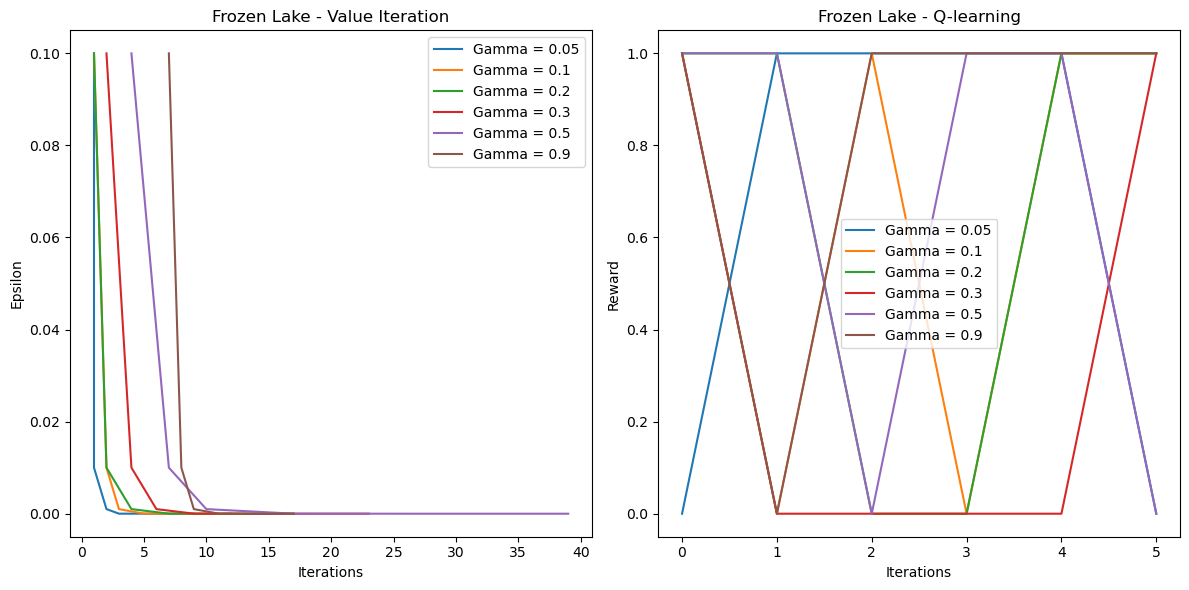

CPU times: total: 16.9 s
Wall time: 17.6 s


In [10]:
%%time 

# Function to run MDP and return the number of iterations
def run_mdp(transitions, rewards, gamma, epsilon, max_iter):
    mdp_instance = mdp.ValueIteration(transitions, rewards, gamma, epsilon=epsilon, max_iter=max_iter)
    result = mdp_instance.run()
    return mdp_instance.iter, result[0]['Reward']

# Frozen Lake MDP parameters
n_states_fl = 16  # Small number of states
n_actions_fl = 4
transitions_fl = np.array([
    [[0.8, 0.1, 0.0, 0.1], [0.1, 0.8, 0.1, 0.0], [0.0, 0.1, 0.8, 0.1], [0.0, 0.0, 0.0, 1.0]],
    [[0.8, 0.1, 0.0, 0.1], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.1, 0.0, 0.1, 0.8]],
    [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.1, 0.9], [0.0, 0.0, 0.1, 0.9]],
    [[0.0, 0.0, 0.1, 0.9], [0.0, 1.0, 0.0, 0.0], [0.1, 0.9, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
])
rewards_fl = np.array([[0, 0, 0, 1], [0, 0, -1, 0], [0, 0, 0, 1], [0, -1, 0, 1]])

# Gamma and Epsilon values to iterate through
gamma_values_fl = [0.05, 0.1, 0.2, 0.3, 0.5, 0.9]
epsilon_values_fl = [1e-1, 1e-2, 1e-3, 1e-5, 1e-8, 1e-12]

# Results storage
results_fl_vi = np.zeros((len(gamma_values_fl), len(epsilon_values_fl)))
results_fl_ql = np.zeros((len(gamma_values_fl), len(epsilon_values_fl)))

# Iterate through gamma and epsilon values for Frozen Lake
for i, gamma in enumerate(gamma_values_fl):
    for j, epsilon in enumerate(epsilon_values_fl):
        iterations, reward = run_mdp(transitions_fl, rewards_fl, gamma, epsilon, max_iter=1000)
        results_fl_vi[i, j] = iterations

        ql_fl = mdp.QLearning(transitions_fl, rewards_fl, gamma, epsilon=epsilon, n_iter=10000)
        ql_fl_result = ql_fl.run()
        results_fl_ql[i, j] = ql_fl_result[-1]['Reward']

# Plotting Frozen Lake
plt.figure(figsize=(12, 6))

# Frozen Lake - Value Iteration
plt.subplot(1, 2, 1)
for i, gamma in enumerate(gamma_values_fl):
    plt.plot(results_fl_vi[i, :], epsilon_values_fl, label=f'Gamma = {gamma}')
plt.title('Frozen Lake - Value Iteration')
plt.xlabel('Iterations')
plt.ylabel('Epsilon')
plt.legend()

# Frozen Lake - Q-learning
plt.subplot(1, 2, 2)
for i, gamma in enumerate(gamma_values_fl):
    plt.plot(results_fl_ql[i, :], label=f'Gamma = {gamma}')
plt.title('Frozen Lake - Q-learning')
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

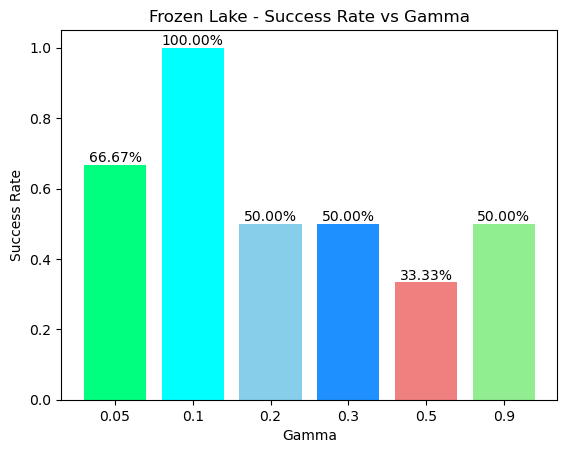

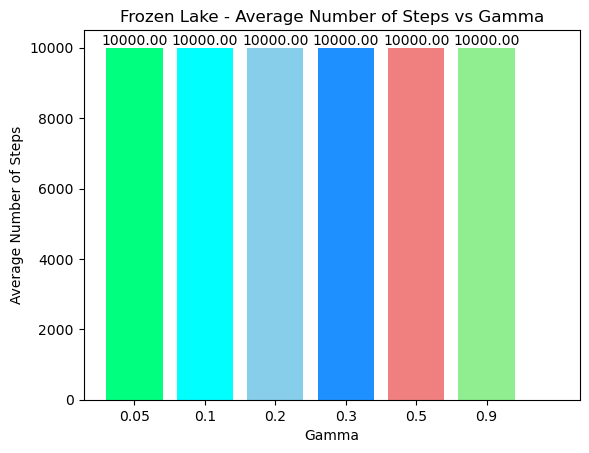

CPU times: total: 16.1 s
Wall time: 18.7 s


In [323]:
%%time

# Function to run MDP and return the relevant information
def run_mdp(transitions, rewards, gamma, epsilon, max_iter):
    mdp_instance = mdp.ValueIteration(transitions, rewards, gamma, epsilon=epsilon, max_iter=max_iter)
    start_time = time.time()
    result = mdp_instance.run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    return pd.Series({
        'Gamma': gamma,
        'Epsilon': epsilon,
        'Time': elapsed_time,
        'Iterations': mdp_instance.iter,
        'Reward': result[0]['Reward'],
        'Max V': result[0]['Max V'],
        'Mean V': result[0]['Mean V'],
        'Error': result[0]['Error']
    })

# Frozen Lake MDP parameters
n_states_fl = 200  # Small number of states
n_actions_fl = 4

transitions_fl = np.array([
    [[0.8, 0.1, 0.0, 0.1], [0.1, 0.8, 0.1, 0.0], [0.0, 0.1, 0.8, 0.1], [0.0, 0.0, 0.0, 1.0]],
    [[0.8, 0.1, 0.0, 0.1], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.1, 0.0, 0.1, 0.8]],
    [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.1, 0.9], [0.0, 0.0, 0.1, 0.9]],
    [[0.0, 0.0, 0.1, 0.9], [0.0, 1.0, 0.0, 0.0], [0.1, 0.9, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
])
rewards_fl = np.array([[0, 0, 0, 1], [0, 0, -1, 0], [0, 0, 0, 1], [0, -1, 0, 1]])

# Gamma and Epsilon values to iterate through
gamma_values_fl = [0.05, 0.1, 0.2, 0.3, 0.5, 0.9]
epsilon_values_fl = [1e-1, 1e-2, 1e-3, 1e-5, 1e-8, 1e-12]

# Results storage
results_fl_vi = []
results_fl_ql = []

# Iterate through gamma and epsilon values for Frozen Lake
for gamma in gamma_values_fl:
    for epsilon in epsilon_values_fl:
        result_vi = run_mdp(transitions_fl, rewards_fl, gamma, epsilon, max_iter=1000)
        results_fl_vi.append(result_vi)

        ql_fl = mdp.QLearning(transitions_fl, rewards_fl, gamma, epsilon=epsilon, n_iter=10000)
        start_time = time.time()
        ql_fl_result = ql_fl.run()
        end_time = time.time()
        elapsed_time = end_time - start_time
        result_ql = pd.Series({
            'Gamma': gamma,
            'Epsilon': epsilon,
            'Time': elapsed_time,
            'Iterations': ql_fl_result[-1]['Iteration'],
            'Reward': ql_fl_result[-1]['Reward'], 
        })
        results_fl_ql.append(result_ql)

# Create Pandas DataFrames
df_fl_vi = pd.DataFrame(results_fl_vi)
df_fl_ql = pd.DataFrame(results_fl_ql)

# Colors for each gamma value
gamma_colors = {'0.05': 'springgreen', '0.1': 'aqua', '0.2': 'skyblue', '0.3': 'dodgerblue',
                '0.5': 'lightcoral', '0.9': 'lightgreen'}

# Success Percentage vs Gamma (Bar Chart)
plt.plot(1, 1)
success_percentage_fl = df_fl_ql.groupby('Gamma')['Reward'].apply(lambda x: (x == 1).sum() / len(x)).reset_index()
success_percentage_fl['Gamma'] = success_percentage_fl['Gamma'].astype(str)  # Convert Gamma to string
success_percentage_fl['Color'] = success_percentage_fl['Gamma'].map(gamma_colors).fillna('gray')  # Fill NaN with gray
bars = plt.bar(success_percentage_fl['Gamma'], success_percentage_fl['Reward'], color=success_percentage_fl['Color'])
plt.title('Frozen Lake - Success Rate vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Success Rate')


# Label each bar with success percentage
for bar, label in zip(bars, success_percentage_fl['Reward']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.2%}', 
             ha='center', va='bottom', color='black', fontsize=10)
plt.show()

# Average Number of Steps vs Gamma (Bar Chart)
plt.plot(6, 6)
avg_steps_fl = df_fl_ql.groupby('Gamma')['Iterations'].mean().reset_index()
avg_steps_fl['Gamma'] = avg_steps_fl['Gamma'].astype(str)  # Convert Gamma to string
avg_steps_fl['Color'] = avg_steps_fl['Gamma'].map(gamma_colors)
default_color = 'gray'  # Default color for NaN values
avg_steps_fl['Color'].fillna(default_color, inplace=True)

bars = plt.bar(avg_steps_fl['Gamma'], avg_steps_fl['Iterations'], color=avg_steps_fl['Color'])
plt.title('Frozen Lake - Average Number of Steps vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Number of Steps')

# Label each bar with the average number of steps
for bar, label in zip(bars, avg_steps_fl['Iterations']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.2f}', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.show()

In [325]:
df_fl_ql.describe()

,Gamma,Epsilon,Time,Iterations,Reward
count,36.000000,3.600000e+01,36.000000,36.0,36.000000
mean,0.341667,1.850167e-02,0.494272,10000.0,0.555556
std,0.293379,3.714173e-02,0.074018,0.0,0.557773
min,0.050000,1.000000e-12,0.460184,10000.0,-1.000000
25%,0.100000,1.000000e-08,0.468232,10000.0,0.000000
50%,0.250000,5.050000e-04,0.472903,10000.0,1.000000
75%,0.500000,1.000000e-02,0.498545,10000.0,1.000000
max,0.900000,1.000000e-01,0.911552,10000.0,1.000000


In [284]:
df_fl_vi

# Assuming df_fl_vi is your DataFrame
min_iterations_df_fl_vi = df_fl_vi.loc[df_fl_vi.groupby('Gamma')['Iterations'].idxmax()]

succ_rate = success_percentage_fl['Reward']

succ_rate = [float(x) for x in succ_rate]

min_iterations_df_fl_vi["Success Rate"] = succ_rate

# Display the resulting DataFrame
min_iterations_df_fl_vi

,Gamma,Epsilon,Time,Iterations,Reward,Max V,Mean V,Error,Success Rate
5,0.05,1.000000e-12,0.001310,9.0,1.0,1.0,0.75,1.0,0.666667
11,0.10,1.000000e-12,0.000197,12.0,1.0,1.0,0.75,1.0,1.000000
17,0.20,1.000000e-12,0.001341,17.0,1.0,1.0,0.75,1.0,0.500000
23,0.30,1.000000e-12,0.001999,23.0,1.0,1.0,0.75,1.0,0.333333
29,0.50,1.000000e-12,0.003041,39.0,1.0,1.0,0.75,1.0,0.500000
35,0.90,1.000000e-12,0.001330,17.0,1.0,1.0,0.75,1.0,0.333333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


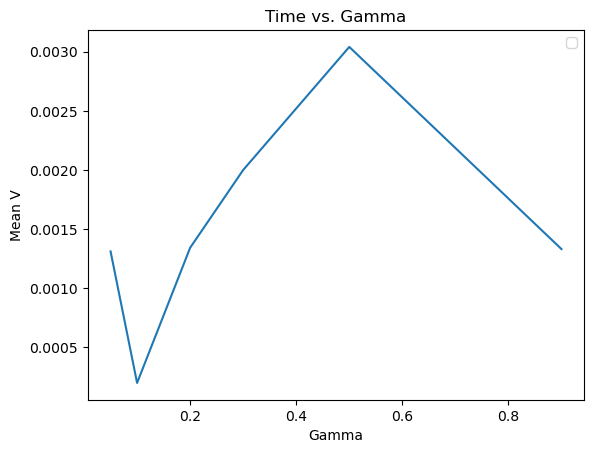

In [287]:
line1, = plt.plot(min_iterations_df_fl_vi['Gamma'], min_iterations_df_fl_vi['Time'])
plt.xlabel('Gamma')
plt.ylabel('Mean V')
plt.title('Time vs. Gamma')
plt.legend(loc='upper right')
plt.show()

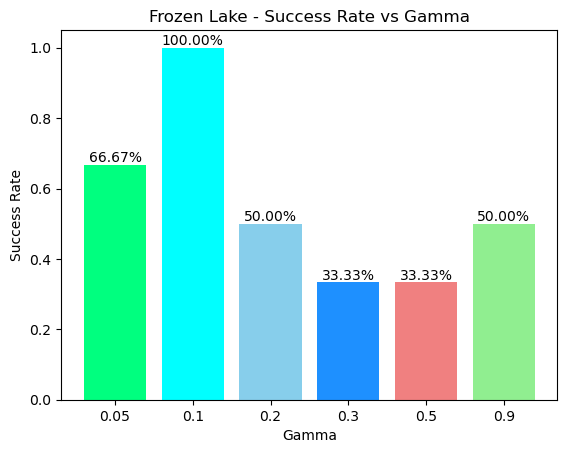

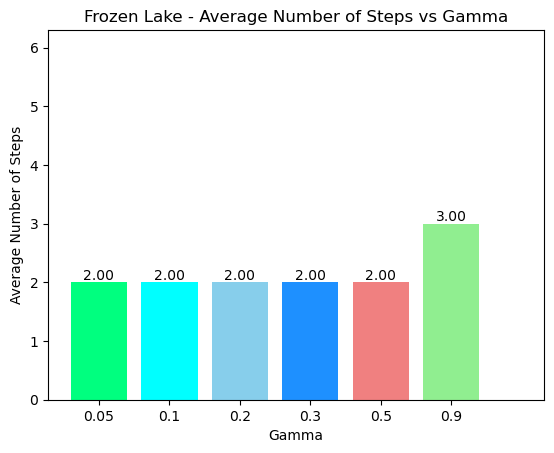

CPU times: total: 15.7 s
Wall time: 18.7 s


In [268]:
%%time

# Function to run MDP and return the relevant information
def run_mdp(transitions, rewards, gamma, epsilon, max_iter):
    mdp_instance = mdp.PolicyIteration(transitions, rewards, gamma)
    start_time = time.time()
    result = mdp_instance.run()
    end_time = time.time()
    elapsed_time = end_time - start_time
    return pd.Series({
        'Gamma': gamma,
        'Epsilon': epsilon,
        'Time': elapsed_time,
        'Iterations': mdp_instance.iter,
        'Reward': result[0]['Reward'],
        'Max V': result[0]['Max V'],
        'Mean V': result[0]['Mean V'],
        'Error': result[0]['Error']
    })

# Frozen Lake MDP parameters
n_states_fl = 200  # Small number of states
n_actions_fl = 4

transitions_fl = np.array([
    [[0.8, 0.1, 0.0, 0.1], [0.1, 0.8, 0.1, 0.0], [0.0, 0.1, 0.8, 0.1], [0.0, 0.0, 0.0, 1.0]],
    [[0.8, 0.1, 0.0, 0.1], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.1, 0.0, 0.1, 0.8]],
    [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.1, 0.9], [0.0, 0.0, 0.1, 0.9]],
    [[0.0, 0.0, 0.1, 0.9], [0.0, 1.0, 0.0, 0.0], [0.1, 0.9, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]
])
rewards_fl = np.array([[0, 0, 0, 1], [0, 0, -1, 0], [0, 0, 0, 1], [0, -1, 0, 1]])

# Gamma and Epsilon values to iterate through
gamma_values_fl = [0.05, 0.1, 0.2, 0.3, 0.5, 0.9]
epsilon_values_fl = [1e-1, 1e-2, 1e-3, 1e-5, 1e-8, 1e-12]

# Results storage
results_fl_vi = []
results_fl_ql = []

# Iterate through gamma and epsilon values for Frozen Lake
for gamma in gamma_values_fl:
    for epsilon in epsilon_values_fl:
        result_vi = run_mdp(transitions_fl, rewards_fl, gamma, epsilon, max_iter=2000)
        results_fl_vi.append(result_vi)

        ql_fl = mdp.QLearning(transitions_fl, rewards_fl, gamma, epsilon=epsilon, n_iter=10000)
        start_time = time.time()
        ql_fl_result = ql_fl.run()
        end_time = time.time()
        elapsed_time = end_time - start_time
        result_ql = pd.Series({
            'Gamma': gamma,
            'Epsilon': epsilon,
            'Time': elapsed_time,
            'Iterations': ql_fl_result[-1]['Iteration'],
            'Reward': ql_fl_result[-1]['Reward']
        })
        results_fl_ql.append(result_ql)

# Create Pandas DataFrames
df_fl_vi = pd.DataFrame(results_fl_vi)
df_fl_ql = pd.DataFrame(results_fl_ql)

# Colors for each gamma value
gamma_colors = {'0.05': 'springgreen', '0.1': 'aqua', '0.2': 'skyblue', '0.3': 'dodgerblue',
                '0.5': 'lightcoral', '0.9': 'lightgreen'}

# Success Percentage vs Gamma (Bar Chart)
plt.plot(1, 1)
success_percentage_fl = df_fl_ql.groupby('Gamma')['Reward'].apply(lambda x: (x == 1).sum() / len(x)).reset_index()
success_percentage_fl['Gamma'] = success_percentage_fl['Gamma'].astype(str)  # Convert Gamma to string
success_percentage_fl['Color'] = success_percentage_fl['Gamma'].map(gamma_colors).fillna('gray')  # Fill NaN with gray
bars = plt.bar(success_percentage_fl['Gamma'], success_percentage_fl['Reward'], color=success_percentage_fl['Color'])
plt.title('Frozen Lake - Success Rate vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Success Rate')


# Label each bar with success percentage
for bar, label in zip(bars, success_percentage_fl['Reward']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.2%}', 
             ha='center', va='bottom', color='black', fontsize=10)
plt.show()

# Average Number of Steps vs Gamma (Bar Chart)
plt.plot(6, 6)
avg_steps_fl = df_fl_vi.groupby('Gamma')['Iterations'].mean().reset_index()
avg_steps_fl['Gamma'] = avg_steps_fl['Gamma'].astype(str)  # Convert Gamma to string
avg_steps_fl['Color'] = avg_steps_fl['Gamma'].map(gamma_colors)
default_color = 'gray'  # Default color for NaN values
avg_steps_fl['Color'].fillna(default_color, inplace=True)

bars = plt.bar(avg_steps_fl['Gamma'], avg_steps_fl['Iterations'], color=avg_steps_fl['Color'])
plt.title('Frozen Lake - Average Number of Steps vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Number of Steps')

# Label each bar with the average number of steps
for bar, label in zip(bars, avg_steps_fl['Iterations']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.2f}', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.show()

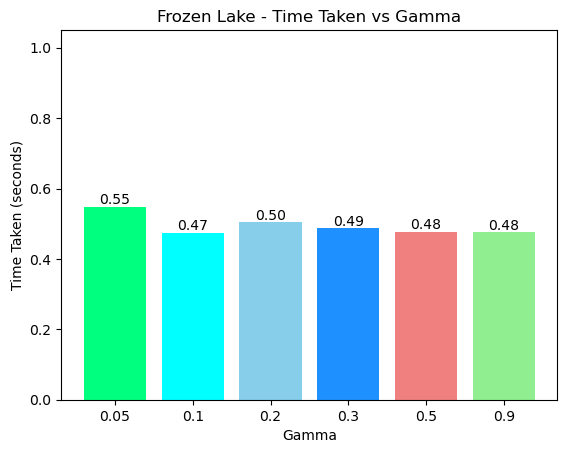

In [327]:
# Time Taken vs Gamma (Bar Chart)
plt.plot(1, 1)
time_taken_fl = df_fl_ql.groupby('Gamma')['Time'].mean().reset_index()
time_taken_fl['Gamma'] = time_taken_fl['Gamma'].astype(str)  # Convert Gamma to string
time_taken_fl['Color'] = time_taken_fl['Gamma'].map(gamma_colors).fillna('gray')  # Fill NaN with gray
bars = plt.bar(time_taken_fl['Gamma'], time_taken_fl['Time'], color=time_taken_fl['Color'])
plt.title('Frozen Lake - Time Taken vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('Time Taken (seconds)')

# Label each bar with the average time taken
for bar, label in zip(bars, time_taken_fl['Time']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{label:.2f}', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.show()

In [301]:
df_fl_vi

,Gamma,Epsilon,Time,Iterations,Reward,Max V,Mean V,Error
0,0.05,1.000000e-01,0.001000,1.0,1.0,1.0,0.75,1.0
1,0.05,1.000000e-02,0.001004,1.0,1.0,1.0,0.75,1.0
2,0.05,1.000000e-03,0.000000,2.0,1.0,1.0,0.75,1.0
3,0.05,1.000000e-05,0.000000,3.0,1.0,1.0,0.75,1.0
4,0.05,1.000000e-08,0.001001,6.0,1.0,1.0,0.75,1.0
5,0.05,1.000000e-12,0.001310,9.0,1.0,1.0,0.75,1.0
6,0.10,1.000000e-01,0.000000,1.0,1.0,1.0,0.75,1.0
7,0.10,1.000000e-02,0.001000,2.0,1.0,1.0,0.75,1.0
8,0.10,1.000000e-03,0.000999,3.0,1.0,1.0,0.75,1.0
9,0.10,1.000000e-05,0.000000,5.0,1.0,1.0,0.75,1.0


In [305]:
# Assuming df_fl_vi is your DataFrame
min_iterations_df_fl_vi = df_fl_vi.loc[df_fl_vi.groupby(['Epsilon'])['Iterations'].idxmin()]

succ_rate = success_percentage_fl['Reward']

succ_rate = [float(x) for x in succ_rate]

min_iterations_df_fl_vi["Success Rate"] = succ_rate

# Display the resulting DataFrame
min_iterations_df_fl_vi

,Gamma,Epsilon,Time,Iterations,Reward,Max V,Mean V,Error,Success Rate
5,0.05,1.000000e-12,0.001310,9.0,1.0,1.0,0.75,1.0,0.666667
4,0.05,1.000000e-08,0.001001,6.0,1.0,1.0,0.75,1.0,1.000000
3,0.05,1.000000e-05,0.000000,3.0,1.0,1.0,0.75,1.0,0.500000
2,0.05,1.000000e-03,0.000000,2.0,1.0,1.0,0.75,1.0,0.333333
1,0.05,1.000000e-02,0.001004,1.0,1.0,1.0,0.75,1.0,0.500000
0,0.05,1.000000e-01,0.001000,1.0,1.0,1.0,0.75,1.0,0.333333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


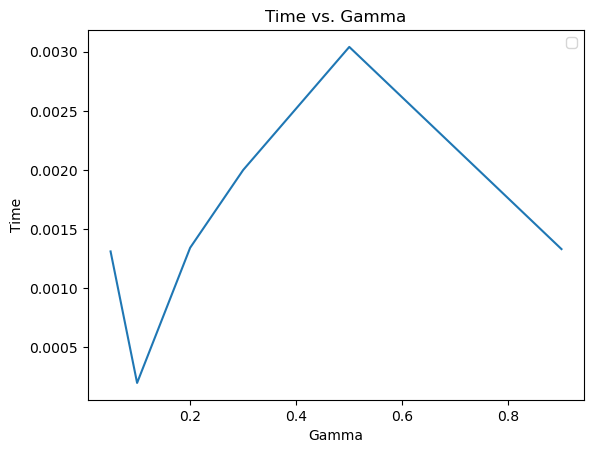

In [289]:
line1, = plt.plot(min_iterations_df_fl_vi['Gamma'], min_iterations_df_fl_vi['Time'])
plt.xlabel('Gamma')
plt.ylabel('Time')
plt.title('Time vs. Gamma')
plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


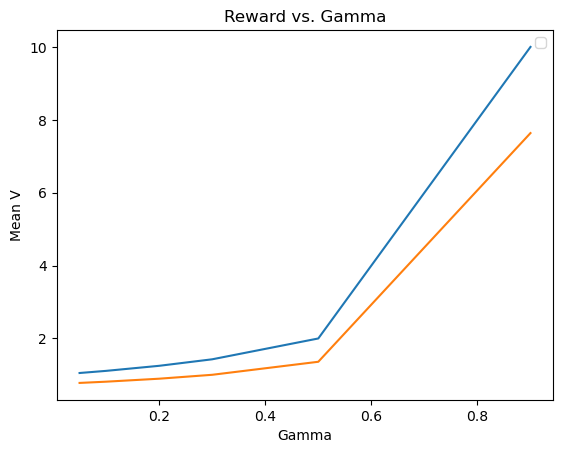

In [276]:
line1, = plt.plot(min_iterations_df_fl_vi['Gamma'], min_iterations_df_fl_vi['Reward'])
line2, = plt.plot(min_iterations_df_fl_vi['Gamma'], min_iterations_df_fl_vi['Mean V'])
plt.xlabel('Gamma')
plt.ylabel('Mean V')
plt.title('Reward vs. Gamma')
plt.legend(loc='upper right')
plt.show()

In [292]:
df_fl_ql

min_iterations_df_fl_ql = df_fl_ql.loc[df_fl_vi.groupby('Gamma')['Iterations'].idxmin()]
min_iterations_df_fl_ql

,Gamma,Epsilon,Time,Iterations,Reward
0,0.05,0.1,0.803172,10000.0,1.0
6,0.10,0.1,0.704930,10000.0,1.0
12,0.20,0.1,0.560182,10000.0,0.0
18,0.30,0.1,0.571401,10000.0,0.0
24,0.50,0.1,0.721683,10000.0,0.0
30,0.90,0.1,0.564867,10000.0,0.0


<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


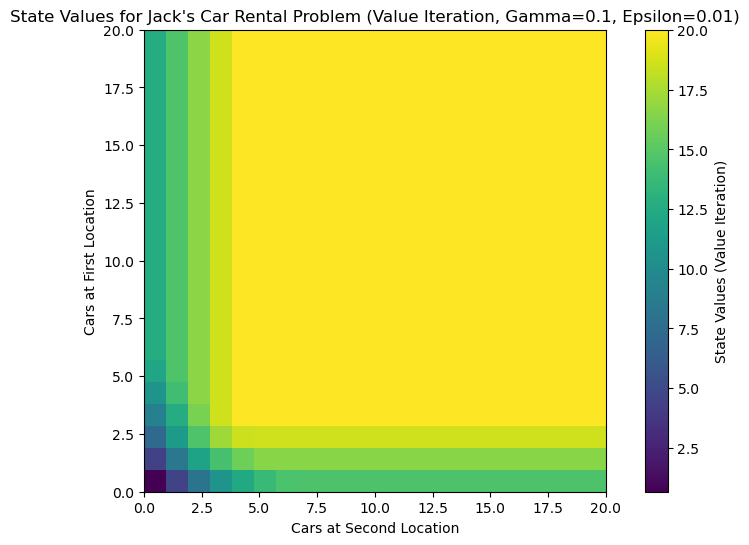

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


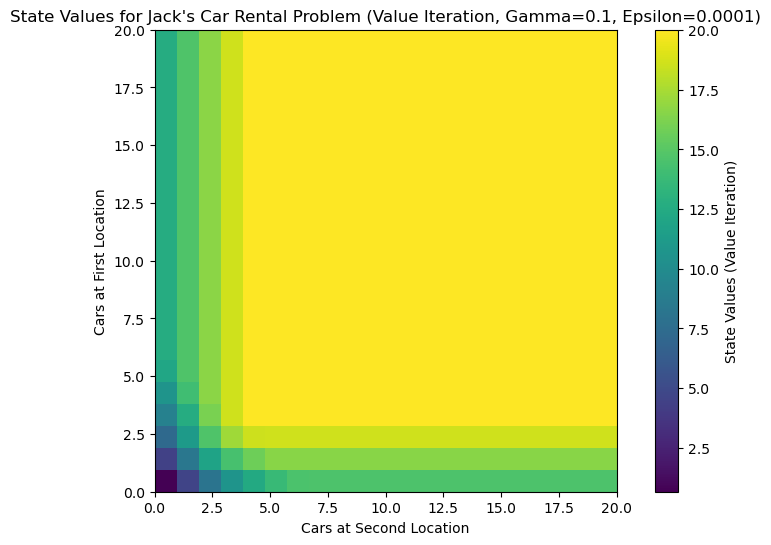

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


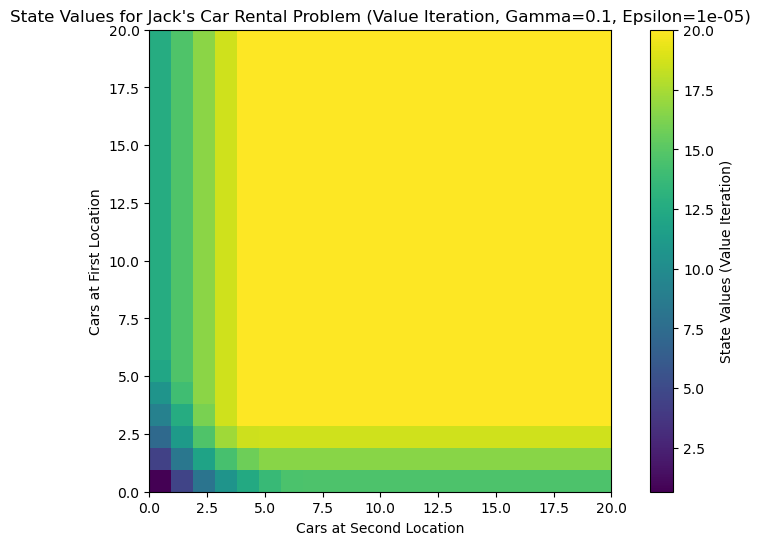

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


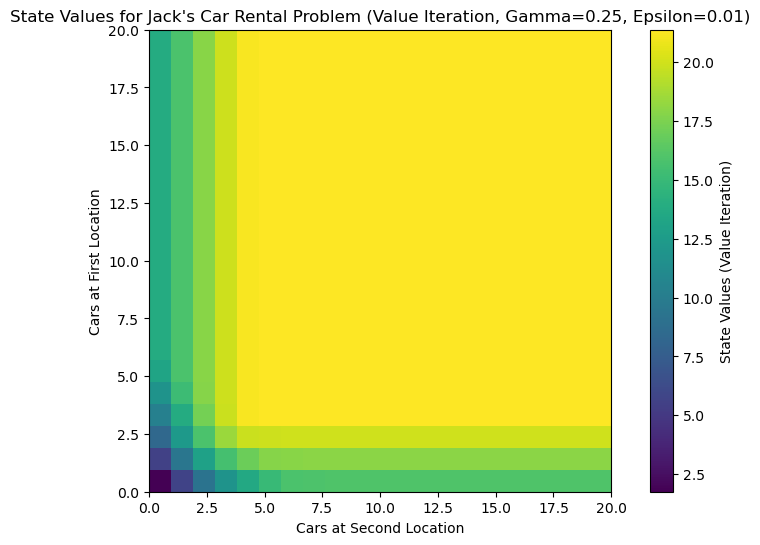

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


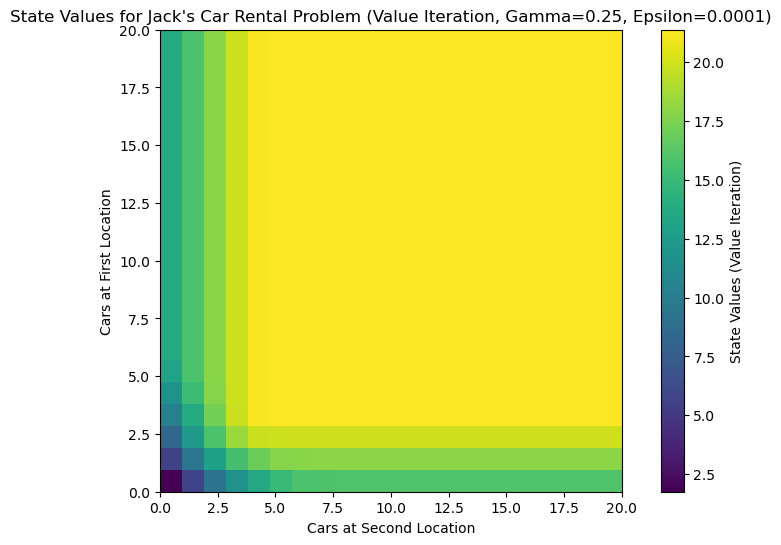

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


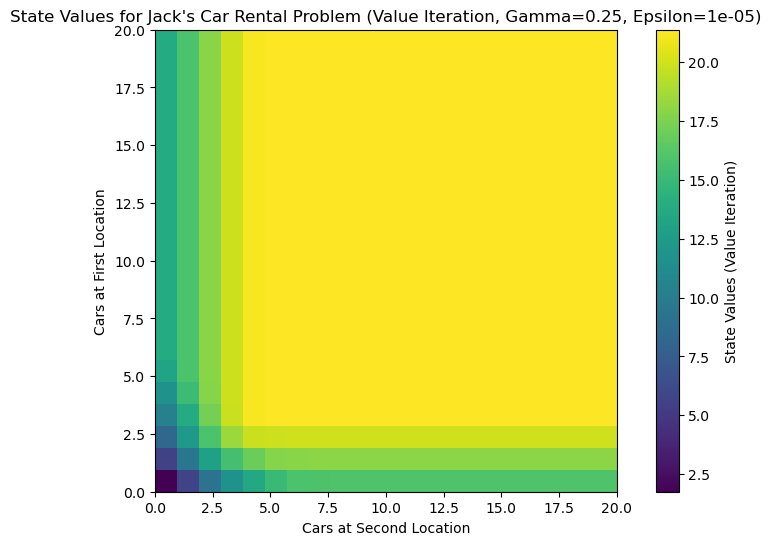

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


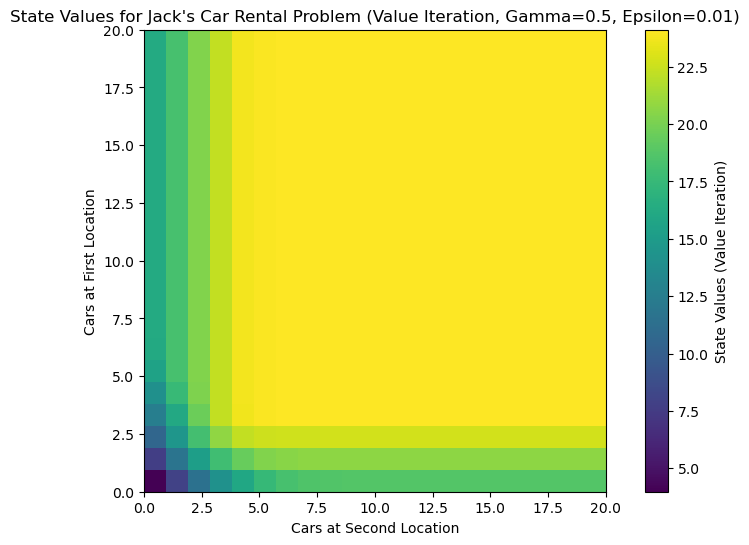

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


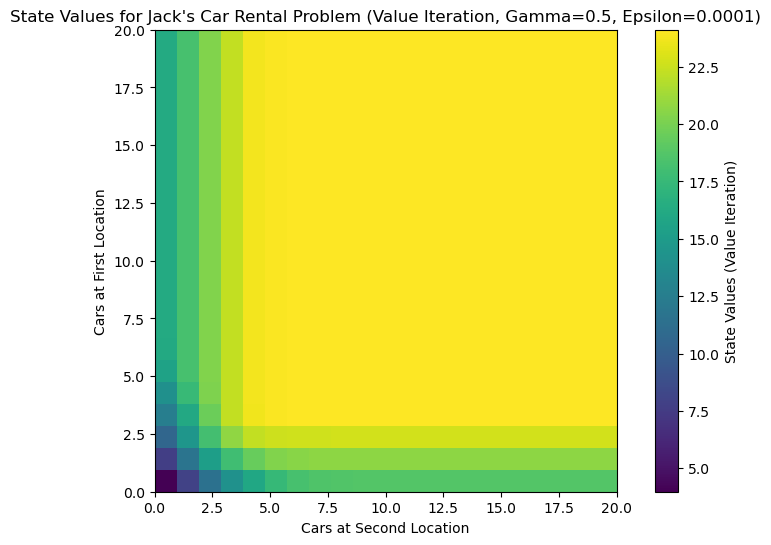

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


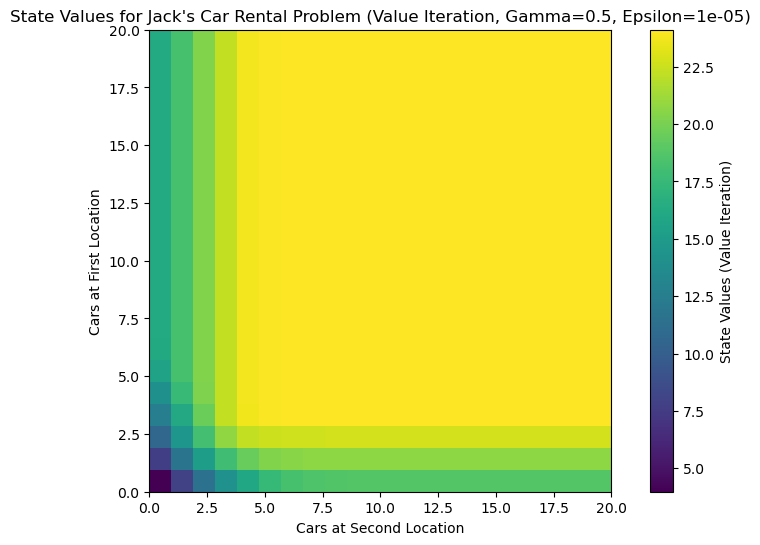

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


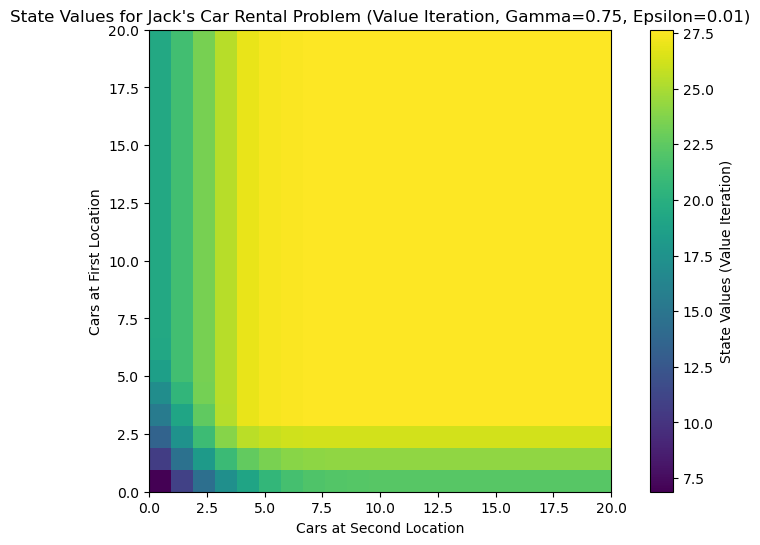

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


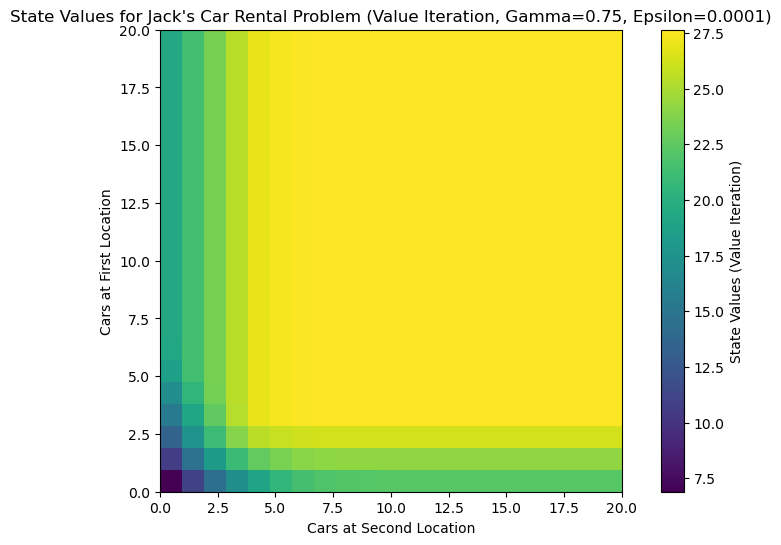

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


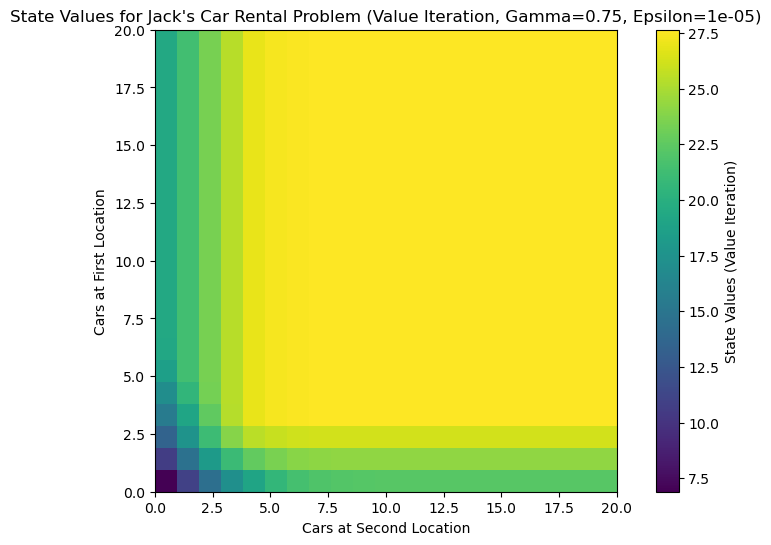

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


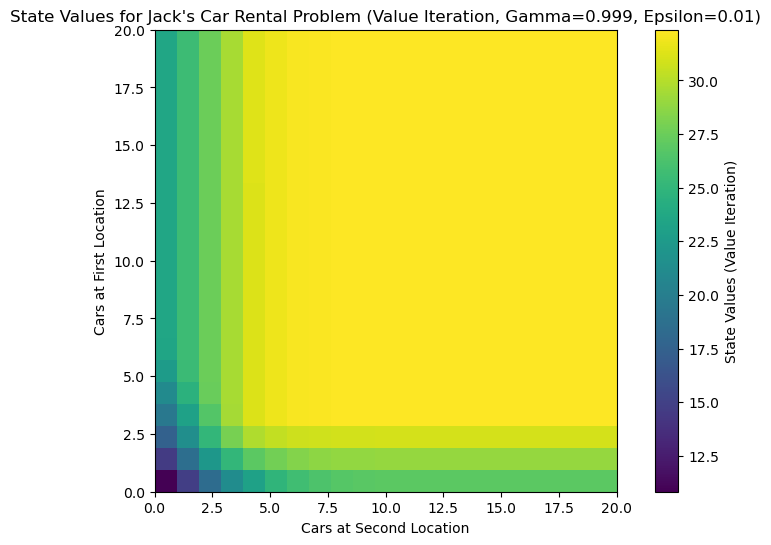

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


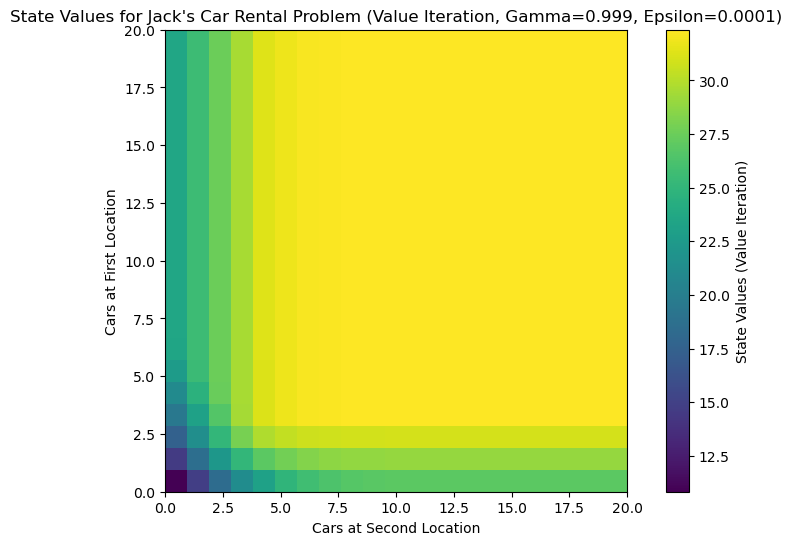

<timed exec>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


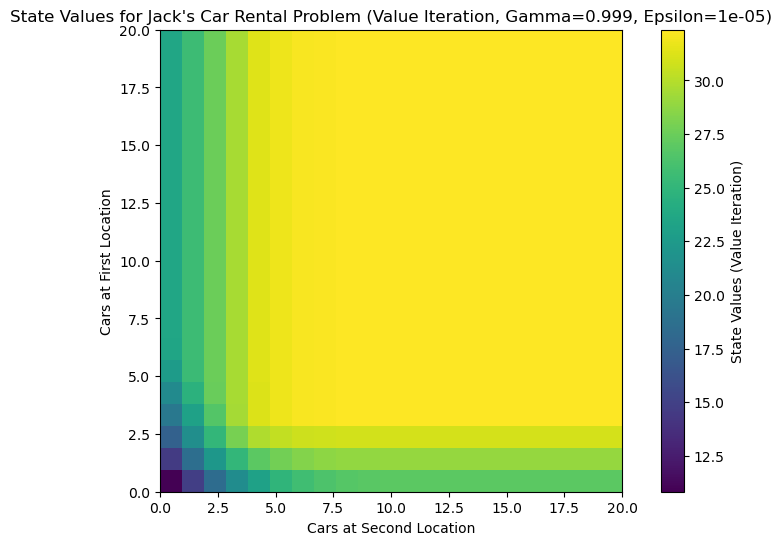

CPU times: total: 35.3 s
Wall time: 42.6 s


,Gamma,Epsilon,Reward,Mean Value,Error,Iterations,Convergence Time
0,0.100,0.01000,8199.512266,18.592998,8.885892e-04,4.0,1.187281
1,0.100,0.00010,8199.519423,18.593015,2.738127e-05,5.0,1.487772
2,0.100,0.00001,8199.519634,18.593015,8.507512e-07,6.0,1.749844
3,0.250,0.01000,8781.102427,19.911797,1.122932e-03,5.0,1.512089
4,0.250,0.00010,8781.125004,19.911848,8.880972e-05,6.0,1.771852
5,0.250,0.00001,8781.126683,19.911852,7.251548e-06,7.0,2.174677
6,0.500,0.01000,9947.719900,22.557188,3.182355e-03,6.0,1.733452
7,0.500,0.00010,9947.863028,22.557513,8.879898e-05,8.0,2.321495
8,0.500,0.00001,9947.866254,22.557520,2.478160e-06,10.0,2.949768
9,0.750,0.01000,11454.347442,25.973577,6.955554e-03,7.0,2.073936


In [328]:
%%time

# Constants
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = 2
RENTAL_CREDIT = 10
RENTAL_REQUEST_FIRST_LOC = 3
RENTAL_REQUEST_SECOND_LOC = 4
RETURNS_FIRST_LOC = 3
RETURNS_SECOND_LOC = 2
MAX_EPISODES = 100

# Different values for gamma and epsilon
gamma_values = [0.1, 0.25, 0.5, 0.75, 0.999]
epsilon_values = [1e-2, 1e-4, 1e-5]

# Results DataFrame for Value Iteration
results_value_iteration_df = pd.DataFrame(columns=['Gamma', 'Epsilon', 'Reward', 'Mean Value', 'Error', 'Iterations'])

# Function to calculate expected return for a given state and action
def expected_return(state, action, state_values):
    returns = 0.0
    returns -= MOVE_COST * abs(action)

    for req_first_loc in range(0, RENTAL_REQUEST_FIRST_LOC + 1):
        for req_second_loc in range(0, RENTAL_REQUEST_SECOND_LOC + 1):
            prob = (np.math.pow(RENTAL_REQUEST_FIRST_LOC, req_first_loc) *
                    np.math.exp(-RENTAL_REQUEST_FIRST_LOC) /
                    np.math.factorial(req_first_loc) *
                    np.math.pow(RENTAL_REQUEST_SECOND_LOC, req_second_loc) *
                    np.math.exp(-RENTAL_REQUEST_SECOND_LOC) /
                    np.math.factorial(req_second_loc))

            num_cars_first_loc = min(state[0] - action, MAX_CARS)
            num_cars_second_loc = min(state[1] + action, MAX_CARS)

            valid_rent_first_loc = min(num_cars_first_loc, req_first_loc)
            valid_rent_second_loc = min(num_cars_second_loc, req_second_loc)

            reward = (valid_rent_first_loc + valid_rent_second_loc) * RENTAL_CREDIT
            num_cars_first_loc -= valid_rent_first_loc
            num_cars_second_loc -= valid_rent_second_loc

            num_cars_first_loc = min(num_cars_first_loc + RETURNS_FIRST_LOC, MAX_CARS)
            num_cars_second_loc = min(num_cars_second_loc + RETURNS_SECOND_LOC, MAX_CARS)

            returns += prob * (reward + gamma * state_values[num_cars_first_loc, num_cars_second_loc])

    return returns

# Loop over different values for gamma and epsilon
for gamma in gamma_values:
    for epsilon in epsilon_values:
        start_time = time.time()
        # Initialize the value function
        state_values = np.zeros((MAX_CARS + 1, MAX_CARS + 1))

        # Value Iteration
        iterations = 0
        while True:
            delta = 0
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    old_value = state_values[i, j]

                    # Greedy policy improvement
                    action_values = [expected_return((i, j), a, state_values) for a in range(-MAX_MOVE, MAX_MOVE + 1)]
                    state_values[i, j] = max(action_values)

                    delta = max(delta, abs(old_value - state_values[i, j]))

            iterations += 1
            if delta < epsilon:
                break
        end_time = time.time()
        convergence_time = end_time - start_time
        
        # Calculate the total reward and mean value
        total_reward = np.sum(state_values)
        mean_value = np.mean(state_values)
        error = delta

        # Append results to the DataFrame
        results_value_iteration_df = results_value_iteration_df.append({
            'Gamma': gamma,
            'Epsilon': epsilon,
            'Reward': total_reward,
            'Mean Value': mean_value,
            'Error': error,
            'Iterations': iterations,
            'Convergence Time': convergence_time
        }, ignore_index=True)

        # Visualize the Value Iteration Result
        plt.figure(figsize=(10, 6))
        plt.imshow(state_values, origin='lower', cmap='viridis', extent=(0, MAX_CARS, 0, MAX_CARS))
        plt.colorbar(label='State Values (Value Iteration)')
        plt.title(f'State Values for Jack\'s Car Rental Problem (Value Iteration, Gamma={gamma}, Epsilon={epsilon})')
        plt.xlabel('Cars at Second Location')
        plt.ylabel('Cars at First Location')
        plt.show()

# Display the results DataFrame for Value Iteration
results_value_iteration_df

In [329]:
results_value_iteration_df.describe()

,Gamma,Epsilon,Reward,Mean Value,Error,Iterations,Convergence Time
count,15.000000,15.000000,15.000000,15.000000,1.500000e+01,15.000000,15.000000
mean,0.519800,0.003370,10369.954720,23.514637,1.191177e-03,8.266667,2.451093
std,0.337652,0.004853,1973.728279,4.475574,2.207905e-03,3.283436,0.971334
min,0.100000,0.000010,8199.512266,18.592998,8.507512e-07,4.000000,1.187281
25%,0.250000,0.000010,8781.113716,19.911822,7.567802e-06,6.000000,1.741648
50%,0.500000,0.000100,9947.863028,22.557513,7.692695e-05,7.000000,2.174677
75%,0.750000,0.010000,11454.854317,25.974726,1.005761e-03,10.500000,3.219339
max,0.999000,0.010000,13466.805479,30.536974,6.955554e-03,15.000000,4.425884


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


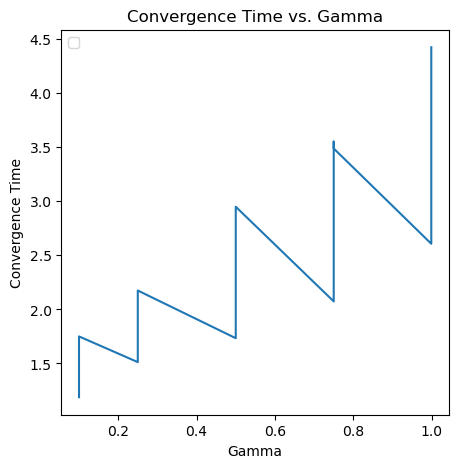

In [331]:
plt.figure(figsize=(5,5))
plt.plot(results_value_iteration_df['Gamma'], results_value_iteration_df['Convergence Time'])
plt.xlabel("Gamma")
plt.ylabel("Convergence Time")
plt.title("Convergence Time vs. Gamma")
plt.legend()
plt.show()

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


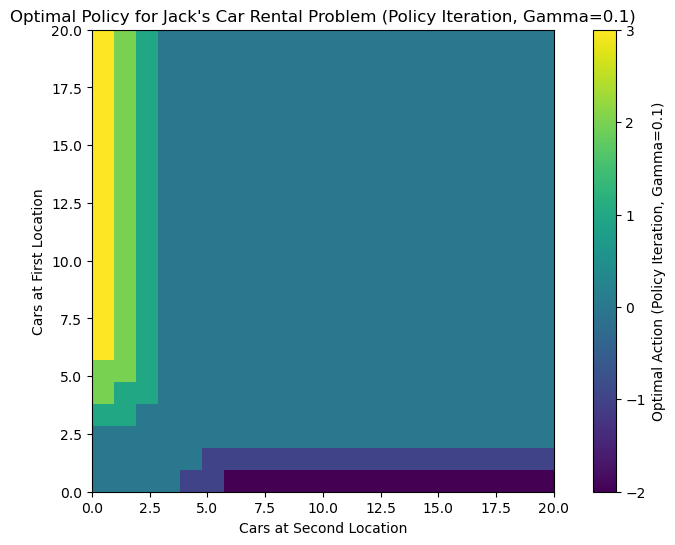

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


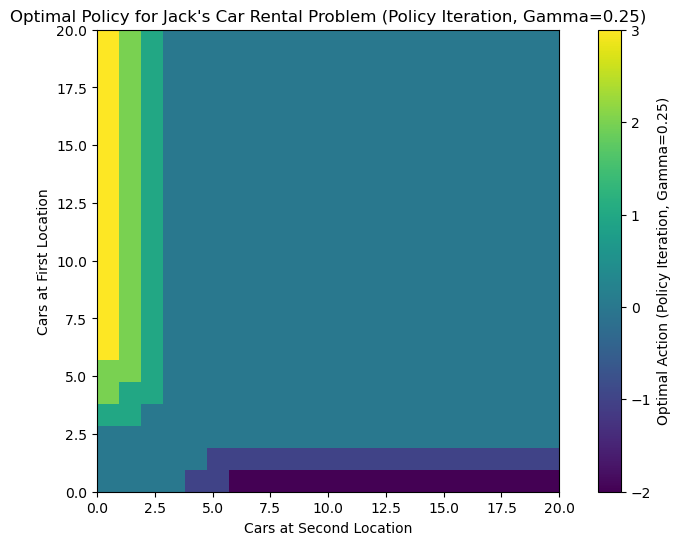

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


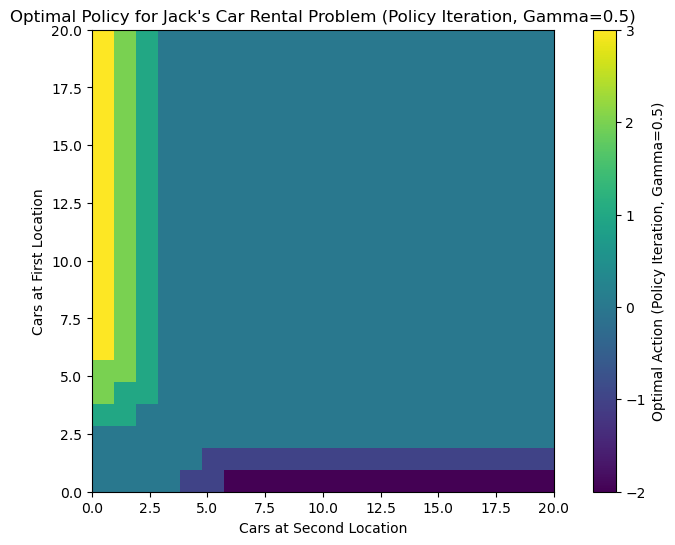

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


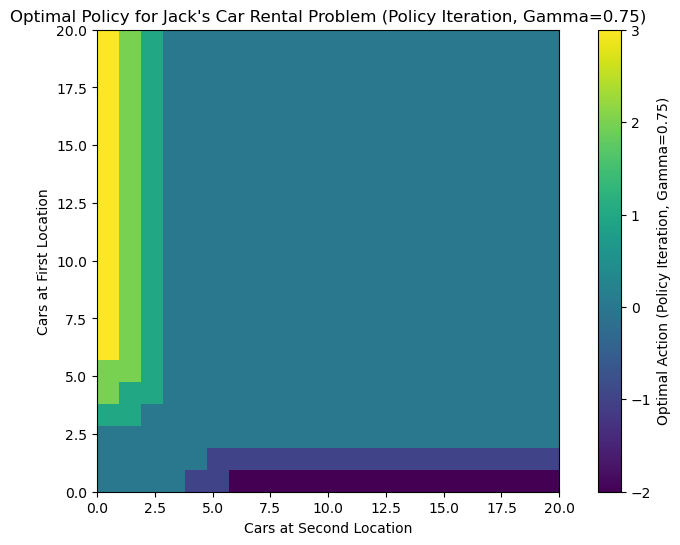

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


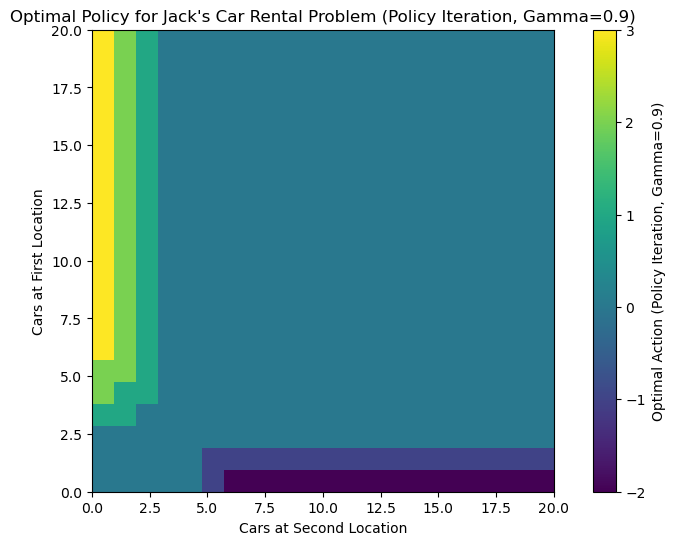

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


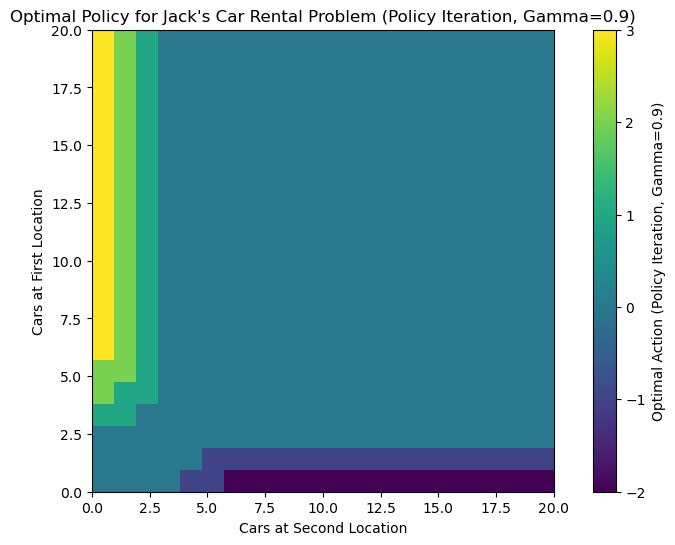

<timed exec>:97: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


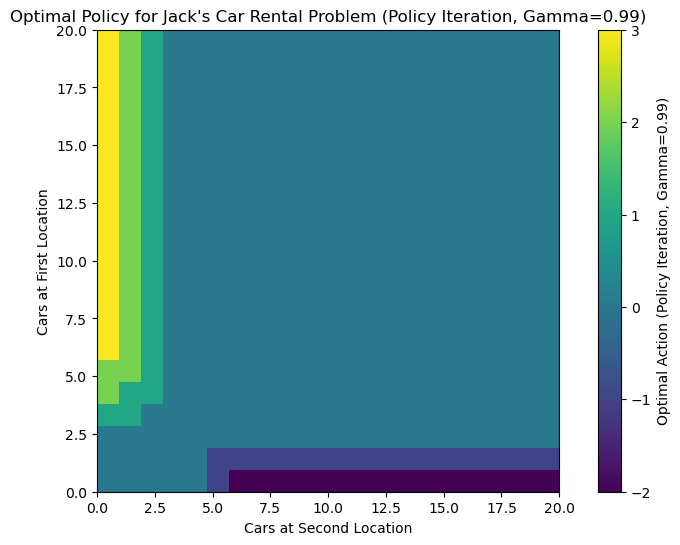

CPU times: total: 8.5 s
Wall time: 11.9 s


,Gamma,Reward,Mean Value,Error,Iterations
0,0.10,8034.622118,18.219098,0.000041,1.0
1,0.25,8611.176577,19.526477,0.000158,1.0
2,0.50,9767.267862,22.148000,0.000197,1.0
3,0.75,11259.425775,25.531578,0.000301,1.0
4,0.90,12382.732248,28.078758,0.000563,1.0
5,0.90,12590.138000,28.549066,0.000514,2.0
6,0.99,13165.960833,29.854786,0.000579,1.0


In [321]:
%%time

# Constants
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = 2
RENTAL_CREDIT = 10
RENTAL_REQUEST_FIRST_LOC = 3
RENTAL_REQUEST_SECOND_LOC = 4
RETURNS_FIRST_LOC = 3
RETURNS_SECOND_LOC = 2
MAX_EPISODES = 100

# Different values for gamma and epsilon
gamma_values = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

# Results DataFrame
results_df = pd.DataFrame(columns=['Gamma', 'Reward', 'Mean Value', 'Error', 'Iterations'])

# Function to calculate expected return for a given state and action
def expected_return(state, action, state_values):
    returns = 0.0
    returns -= MOVE_COST * abs(action)

    for req_first_loc in range(0, RENTAL_REQUEST_FIRST_LOC + 1):
        for req_second_loc in range(0, RENTAL_REQUEST_SECOND_LOC + 1):
            prob = (np.math.pow(RENTAL_REQUEST_FIRST_LOC, req_first_loc) *
                    np.math.exp(-RENTAL_REQUEST_FIRST_LOC) /
                    np.math.factorial(req_first_loc) *
                    np.math.pow(RENTAL_REQUEST_SECOND_LOC, req_second_loc) *
                    np.math.exp(-RENTAL_REQUEST_SECOND_LOC) /
                    np.math.factorial(req_second_loc))

            num_cars_first_loc = min(state[0] - action, MAX_CARS)
            num_cars_second_loc = min(state[1] + action, MAX_CARS)

            valid_rent_first_loc = min(num_cars_first_loc, req_first_loc)
            valid_rent_second_loc = min(num_cars_second_loc, req_second_loc)

            reward = (valid_rent_first_loc + valid_rent_second_loc) * RENTAL_CREDIT
            num_cars_first_loc -= valid_rent_first_loc
            num_cars_second_loc -= valid_rent_second_loc

            num_cars_first_loc = min(num_cars_first_loc + RETURNS_FIRST_LOC, MAX_CARS)
            num_cars_second_loc = min(num_cars_second_loc + RETURNS_SECOND_LOC, MAX_CARS)

            returns += prob * (reward + gamma * state_values[num_cars_first_loc, num_cars_second_loc])

    return returns

# Loop over different values for gamma and epsilon
for gamma in gamma_values:
    
    # Initialize the value function and policy
    state_values = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros_like(state_values, dtype=int)

    # Policy Iteration
    iterations = 0
    for _ in range(MAX_EPISODES):
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    old_value = state_values[i, j]
                    action = policy[i, j]

                    state_values[i, j] = expected_return((i, j), action, state_values)

                    delta = max(delta, abs(old_value - state_values[i, j]))

            if delta < epsilon:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]

                # Greedy policy improvement
                action_values = [expected_return((i, j), a, state_values) for a in range(-MAX_MOVE, MAX_MOVE + 1)]
                policy[i, j] = np.argmax(action_values) - MAX_MOVE

                if old_action != policy[i, j]:
                    policy_stable = False

        iterations += 1
        if policy_stable:
            break

        # Calculate the total reward and mean value
        total_reward = np.sum(state_values)
        mean_value = np.mean(state_values)
        error = delta

        # Append results to the DataFrame
        results_df = results_df.append({
            'Gamma': gamma,
            'Reward': total_reward,
            'Mean Value': mean_value,
            'Error': error,
            'Iterations': iterations
        }, ignore_index=True)

        # Visualize the Policy Iteration Result
        plt.figure(figsize=(10, 6))
        plt.imshow(policy, origin='lower', cmap='viridis', extent=(0, MAX_CARS, 0, MAX_CARS))
        plt.colorbar(label=f'Optimal Action (Policy Iteration, Gamma={gamma})')
        plt.title(f'Optimal Policy for Jack\'s Car Rental Problem (Policy Iteration, Gamma={gamma})')
        plt.xlabel('Cars at Second Location')
        plt.ylabel('Cars at First Location')
        plt.show()

# Display the results DataFrame
results_df

In [322]:
results_df.describe()

,Gamma,Reward,Mean Value,Error,Iterations
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.627143,10830.189059,24.558252,0.000336,1.142857
std,0.349271,2041.931151,4.630229,0.000217,0.377964
min,0.100000,8034.622118,18.219098,0.000041,1.000000
25%,0.375000,9189.222219,20.837239,0.000178,1.000000
50%,0.750000,11259.425775,25.531578,0.000301,1.000000
75%,0.900000,12486.435124,28.313912,0.000538,1.000000
max,0.990000,13165.960833,29.854786,0.000579,2.000000
